# Cards Image Classification

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

2023-11-30 10:33:59.472674: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 10:33:59.518301: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 10:33:59.736389: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 10:33:59.736430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 10:33:59.737661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
batch_size = 32
img_height = 150
img_width = 150

In [3]:
train_folder="./train"
valid_folder="./valid"
test_folder="./test"

In [4]:
def preprocessing(folder):

    AUTOTUNE = tf.data.AUTOTUNE

    ds = tf.keras.utils.image_dataset_from_directory(
        folder,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    
    label_to_class_name = dict(zip(range(len(ds.class_names)), ds.class_names))

    ds = ds.map(lambda x,y:(x/255,y))

    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)

    return ds, label_to_class_name


In [5]:
def plot_existing_graph(img_acc, img_loss):

    accuracy = cv2.imread(img_acc)
    accuracy = cv2.cvtColor(accuracy, cv2.COLOR_BGR2RGB)
    plt.imshow(accuracy)
    plt.axis('off')
    plt.show()

    loss = cv2.imread(img_loss)
    loss = cv2.cvtColor(loss, cv2.COLOR_BGR2RGB)
    plt.imshow(loss)
    plt.axis('off')
    plt.show()

In [6]:
def plot_history_graph(history, img_acc, img_loss):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Précision du modèle')
    plt.ylabel('Précision')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(img_acc)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perte du modèle')
    plt.ylabel('Perte')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(img_loss)
    plt.show()

## Dataset

Dataset used: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/code

In [13]:
# show few exemple of dataset
cards_csv = pd.read_csv('cards.csv')
cards_csv 

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
...,...,...,...,...,...
8150,52,valid/two of spades/1.jpg,two of spades,two,valid
8151,52,valid/two of spades/2.jpg,two of spades,two,valid
8152,52,valid/two of spades/3.jpg,two of spades,two,valid
8153,52,valid/two of spades/4.jpg,two of spades,two,valid


In [8]:
example1 = cv2.imread('train/ace of clubs/003.jpg')
example1 = cv2.cvtColor(example1, cv2.COLOR_BGR2RGB)
example2 = cv2.imread('train/king of hearts/006.jpg')
example2 = cv2.cvtColor(example2, cv2.COLOR_BGR2RGB)
example3 = cv2.imread('train/two of diamonds/002.jpg')
example3 = cv2.cvtColor(example3, cv2.COLOR_BGR2RGB)

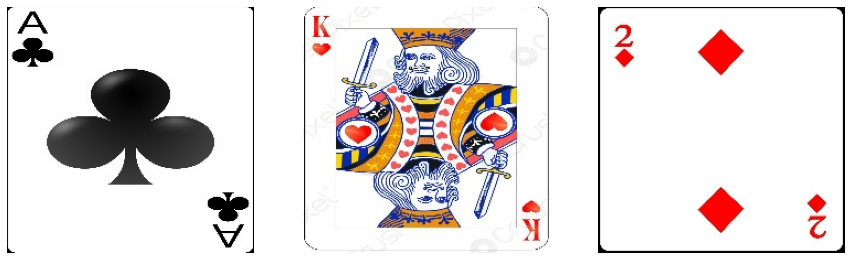

In [9]:
# afficher les trois images
plt.figure(figsize=(15,15))

plt.subplot(131)
plt.imshow(example1)
plt.axis('off')

plt.subplot(132)
plt.imshow(example2)
plt.axis('off')

plt.subplot(133)
plt.imshow(example3)
plt.axis('off')

plt.show()

In [10]:
# affichier le nombre de données d'entrainement par classe
train_csv = cards_csv.loc[cards_csv['data set'] == 'train']
print("Nombre de données d'entrainement par classe")
print(train_csv.groupby('labels')['class index'].count())

Nombre de données d'entrainement par classe
labels
ace of clubs         121
ace of diamonds      129
ace of hearts        171
ace of spades        181
eight of clubs       138
eight of diamonds    159
eight of hearts      152
eight of spades      135
five of clubs        150
five of diamonds     138
five of hearts       136
five of spades       158
four of clubs        157
four of diamonds     114
four of hearts       154
four of spades       140
jack of clubs        171
jack of diamonds     160
jack of hearts       168
jack of spades       172
joker                115
king of clubs        128
king of diamonds     135
king of hearts       125
king of spades       151
nine of clubs        124
nine of diamonds     129
nine of hearts       133
nine of spades       154
queen of clubs       161
queen of diamonds    163
queen of hearts      139
queen of spades      162
seven of clubs       108
seven of diamonds    124
seven of hearts      143
seven of spades      165
six of clubs         152

In [11]:
# Nombre de données de test par classe
test_csv = cards_csv.loc[cards_csv['data set'] == 'test']
print("Nombre de données de test par classe")
print(test_csv.groupby('labels')['class index'].count())

Nombre de données de test par classe
labels
ace of clubs         5
ace of diamonds      5
ace of hearts        5
ace of spades        5
eight of clubs       5
eight of diamonds    5
eight of hearts      5
eight of spades      5
five of clubs        5
five of diamonds     5
five of hearts       5
five of spades       5
four of clubs        5
four of diamonds     5
four of hearts       5
four of spades       5
jack of clubs        5
jack of diamonds     5
jack of hearts       5
jack of spades       5
joker                5
king of clubs        5
king of diamonds     5
king of hearts       5
king of spades       5
nine of clubs        5
nine of diamonds     5
nine of hearts       5
nine of spades       5
queen of clubs       5
queen of diamonds    5
queen of hearts      5
queen of spades      5
seven of clubs       5
seven of diamonds    5
seven of hearts      5
seven of spades      5
six of clubs         5
six of diamonds      5
six of hearts        5
six of spades        5
ten of clubs 

In [12]:
# Nombre de données de validation par classe
validation_csv = cards_csv.loc[cards_csv['data set'] == 'valid']
print("Nombre de données de validation par classe")
print(validation_csv.groupby('labels')['class index'].count())

Nombre de données de validation par classe
labels
ace of clubs         5
ace of diamonds      5
ace of hearts        5
ace of spades        5
eight of clubs       5
eight of diamonds    5
eight of hearts      5
eight of spades      5
five of clubs        5
five of diamonds     5
five of hearts       5
five of spades       5
four of clubs        5
four of diamonds     5
four of hearts       5
four of spades       5
jack of clubs        5
jack of diamonds     5
jack of hearts       5
jack of spades       5
joker                5
king of clubs        5
king of diamonds     5
king of hearts       5
king of spades       5
nine of clubs        5
nine of diamonds     5
nine of hearts       5
nine of spades       5
queen of clubs       5
queen of diamonds    5
queen of hearts      5
queen of spades      5
seven of clubs       5
seven of diamonds    5
seven of hearts      5
seven of spades      5
six of clubs         5
six of diamonds      5
six of hearts        5
six of spades        5
ten of 

# Classification model : type and color

## Preprocessing

In [6]:
train_ds, label_to_class_name = preprocessing(train_folder)
val_ds, _ = preprocessing(valid_folder)
test_ds, _ = preprocessing(test_folder)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


## Model construction

In [7]:
# model construction
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (img_height, img_width, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(53, activation=tf.nn.softmax)
])

# model visualisation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [8]:
# model compilation
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

## Model training

In [9]:
# Model training
epochs=15
if os.path.exists('model_type_color_'+str(epochs)+'_'+str(batch_size)+'.h5'):
  model = tf.keras.models.load_model('model_type_color_'+str(epochs)+'_'+str(batch_size)+'.h5')
else:
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )
  # Model saving
  model.save('model_type_color_'+str(epochs)+'_'+str(batch_size)+'.h5')

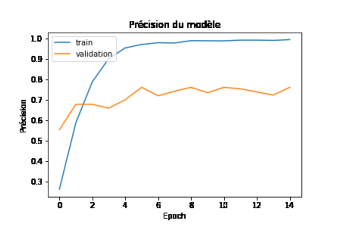

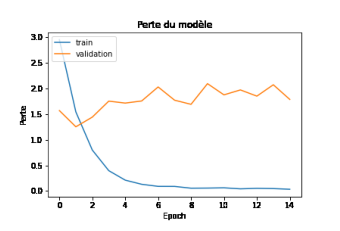

In [10]:
# Visualisation of training graphs
accuracy_graph = 'accuracy_type_color_'+str(epochs)+'_'+str(batch_size)+'.png'
loss_graph = 'loss_type_color_'+str(epochs)+'_'+str(batch_size)+'.png'
if os.path.exists(accuracy_graph) and os.path.exists(loss_graph):
    plot_existing_graph(accuracy_graph, loss_graph)

else:
    plot_history_graph(history, accuracy_graph, loss_graph)

## Model evaluation

In [11]:
# model evaluation
model.evaluate(test_ds)

9/9 [==============================] - 1s 77ms/step - loss: 2.3321 - accuracy: 0.7245


[2.3320705890655518, 0.7245283126831055]

In [14]:
df_test=cards_csv[cards_csv['data set']=='test']
label_encoder = LabelEncoder()
df_test['labels_num']=label_encoder.fit_transform(df_test.labels)
label=cards_csv.labels.unique()

df_test.head()

/tmp/ipykernel_8420/2988387662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['labels_num']=label_encoder.fit_transform(df_test.labels)


,class index,filepaths,labels,card type,data set,labels_num
7625,0,test/ace of clubs/1.jpg,ace of clubs,ace,test,0
7626,0,test/ace of clubs/2.jpg,ace of clubs,ace,test,0
7627,0,test/ace of clubs/3.jpg,ace of clubs,ace,test,0
7628,0,test/ace of clubs/4.jpg,ace of clubs,ace,test,0
7629,0,test/ace of clubs/5.jpg,ace of clubs,ace,test,0


In [15]:
pred=[]
for loc in df_test.filepaths:
    img = cv2.imread(loc)
    resize = tf.image.resize(img, (150,150))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    max_index = np.argmax(yhat)
    pred.append(max_index)
df_test['pred_label']=pred

1/1 [==============================] - 0s 21ms/step


/tmp/ipykernel_8420/4111919033.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label']=pred


In [16]:
class_report = classification_report(df_test['labels_num'],df_test['pred_label'],target_names=label)
print("Classification Report:\n", class_report)

Classification Report:
                    precision    recall  f1-score   support

     ace of clubs       0.62      1.00      0.77         5
  ace of diamonds       1.00      0.60      0.75         5
    ace of hearts       0.60      0.60      0.60         5
    ace of spades       0.45      1.00      0.62         5
   eight of clubs       0.36      1.00      0.53         5
eight of diamonds       0.33      0.20      0.25         5
  eight of hearts       0.75      0.60      0.67         5
  eight of spades       0.50      0.40      0.44         5
    five of clubs       0.40      0.40      0.40         5
 five of diamonds       1.00      0.20      0.33         5
   five of hearts       1.00      0.40      0.57         5
   five of spades       0.40      0.80      0.53         5
    four of clubs       0.60      0.60      0.60         5
 four of diamonds       0.67      0.40      0.50         5
   four of hearts       0.60      0.60      0.60         5
   four of spades       0.50   

/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

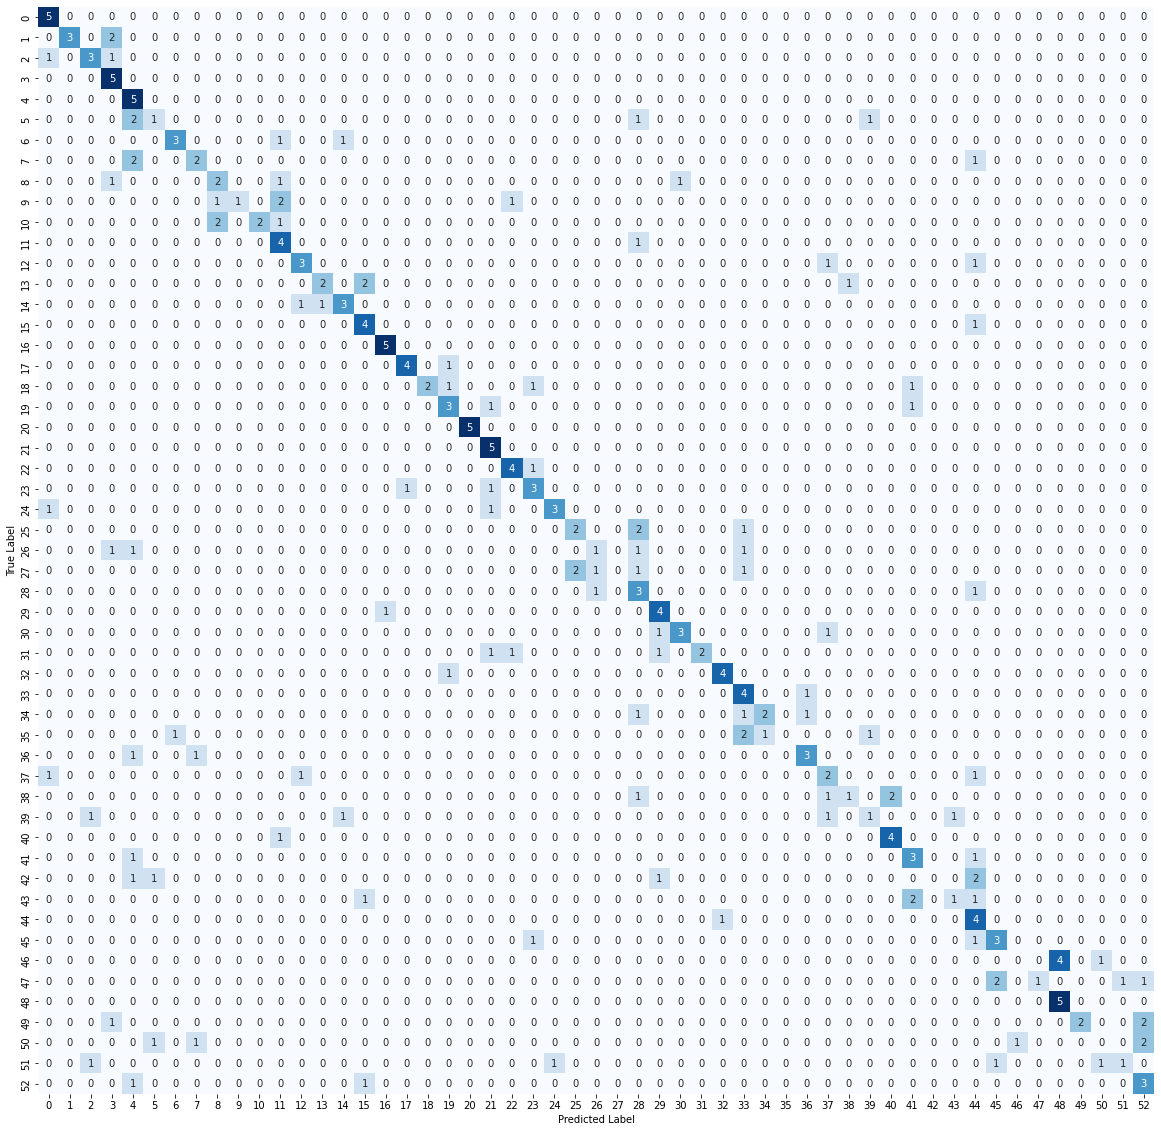

In [17]:
# Confusion matrix
confusion_matrix_type_color = confusion_matrix(df_test['labels_num'], df_test['pred_label'])
# plot confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix_type_color, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Here are the errors made by the model on the test set:

In [30]:
unique_classes = df_test['class index'].unique()

class_label_dict = {}

for class_index in unique_classes:
    labels_for_class = df_test[df_test['class index'] == class_index]['labels'].unique()
    class_label_dict[class_index] = labels_for_class[0]

In [31]:
errors = []

for i in range(len(df_test['labels_num'])):
    if df_test['labels_num'].iloc[i] != df_test['pred_label'].iloc[i]:
        errors.append(i)

# Afficher les exemples d'erreurs
for error_index in errors:
    true_label = df_test['labels_num'].iloc[error_index]
    predicted_label = df_test['pred_label'].iloc[error_index]
    
    print(f"Vraie classe : {class_label_dict[true_label]}, Classe prédite : {class_label_dict[predicted_label]}")
    print("------")

Vraie classe : ace of diamonds, Classe prédite : ace of spades
------
Vraie classe : ace of diamonds, Classe prédite : ace of spades
------
Vraie classe : ace of hearts, Classe prédite : ace of spades
------
Vraie classe : ace of hearts, Classe prédite : ace of clubs
------
Vraie classe : eight of diamonds, Classe prédite : nine of spades
------
Vraie classe : eight of diamonds, Classe prédite : eight of clubs
------
Vraie classe : eight of diamonds, Classe prédite : eight of clubs
------
Vraie classe : eight of diamonds, Classe prédite : six of hearts
------
Vraie classe : eight of hearts, Classe prédite : five of spades
------
Vraie classe : eight of hearts, Classe prédite : four of hearts
------
Vraie classe : eight of spades, Classe prédite : ten of spades
------
Vraie classe : eight of spades, Classe prédite : eight of clubs
------
Vraie classe : eight of spades, Classe prédite : eight of clubs
------
Vraie classe : five of clubs, Classe prédite : ace of spades
------
Vraie classe

Let's try the model on a random image from the test set:

1/1 [==============================] - 0s 27ms/step
ace of clubs


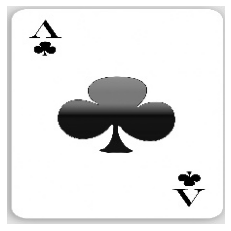

In [23]:
# test on an image
img = cv2.imread('test/ace of clubs/2.jpg')
resize = tf.image.resize(img, (150,150))
yhat = model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(label_to_class_name[max_index])
plt.imshow(img)
plt.axis('off')
plt.show()

# Classification model : color

In [32]:
train_folder_color="./train_color"
test_folder_color="./test_color"
valid_folder_color="./valid_color"

## Process database

In [33]:
def process_database_color(source_folder, destination_folder):
    json_data = []

    for directory in os.listdir(source_folder):
        directory_path = os.path.join(source_folder, directory)

        if directory != 'joker':

            for image in os.listdir(directory_path):
                image_path = os.path.join(directory_path, image)
                
                class_label = directory.split(' ')[-1]

                destination_folder_class = os.path.join(destination_folder, class_label)
                if not os.path.exists(destination_folder_class):
                    os.makedirs(destination_folder_class)

                new_name = directory + '_' + image
                destination_path_image = os.path.join(destination_folder_class, new_name)

                shutil.copy(image_path, destination_path_image)

                json_data.append({'filepaths': destination_path_image, 
                                'labels': class_label})

    df = pd.DataFrame(json_data)
    labels = ['clubs', 'diamonds', 'hearts', 'spades']
    df['class index'] = df['labels'].apply(lambda x: labels.index(x))

    return df          


In [34]:
df_train_color = process_database_color(train_folder, train_folder_color)

In [35]:
df_test_color = process_database_color(test_folder, test_folder_color)

In [36]:
df_valid_color = process_database_color(valid_folder, valid_folder_color)

## Preprocessing

In [37]:
train_color_ds, label_to_class_name = preprocessing(train_folder_color)
val_color_ds, _ = preprocessing(valid_folder_color)
test_color_ds, _ = preprocessing(test_folder_color)

Found 7509 files belonging to 4 classes.
Found 260 files belonging to 4 classes.
Found 260 files belonging to 4 classes.


## Model construction

In [38]:
# Model construction
model_color = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

# Model visualisation
model_color.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [39]:
# Model compilation
model_color.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

## Model training

In [42]:
# Model training
epochs=10
if os.path.exists('model_color_'+str(epochs)+'_'+str(batch_size)+'.h5'):
  model_color = tf.keras.models.load_model('model_color_'+str(epochs)+'_'+str(batch_size)+'.h5')
else:
  history = model_color.fit(
    train_color_ds,
    validation_data=val_color_ds,
    epochs=epochs
  )
  # Model saving
  model_color.save('model_color_'+str(epochs)+'_'+str(batch_size)+'.h5')

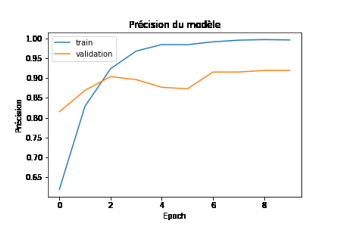

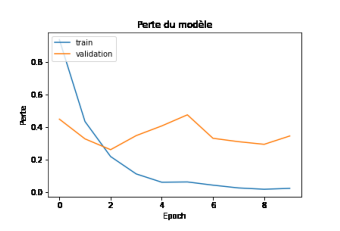

In [43]:
# Visualisation of training graph
if os.path.exists('accuracy_color_'+str(epochs)+'_'+str(batch_size)+'.png') and os.path.exists('loss_color_'+str(epochs)+'_'+str(batch_size)+'.png'):
    plot_existing_graph('accuracy_color_'+str(epochs)+'_'+str(batch_size)+'.png', 'loss_color_'+str(epochs)+'_'+str(batch_size)+'.png')

else:
    plot_history_graph(history, 'accuracy_color_'+str(epochs)+'_'+str(batch_size)+'.png', 'loss_color_'+str(epochs)+'_'+str(batch_size)+'.png')

## Model evaluation

In [44]:
# Model evaluation
model_color.evaluate(test_color_ds)

9/9 [==============================] - 1s 64ms/step - loss: 0.2691 - accuracy: 0.9423


[0.26913216710090637, 0.942307710647583]

In [45]:
label_encoder = LabelEncoder()
df_test_color['labels_num']=label_encoder.fit_transform(df_test_color.labels)
label=df_test_color.labels.unique()

df_test_color.head()

,filepaths,labels,class index,labels_num
0,./test_color/clubs/king of clubs_2.jpg,clubs,0,0
1,./test_color/clubs/king of clubs_4.jpg,clubs,0,0
2,./test_color/clubs/king of clubs_5.jpg,clubs,0,0
3,./test_color/clubs/king of clubs_1.jpg,clubs,0,0
4,./test_color/clubs/king of clubs_3.jpg,clubs,0,0


In [46]:
pred=[]
for loc in df_test_color.filepaths:
    img = cv2.imread(loc)
    resize = tf.image.resize(img, (150,150))
    yhat = model_color.predict(np.expand_dims(resize/255, 0))
    max_index = np.argmax(yhat)
    pred.append(max_index)
df_test_color['pred_label']=pred

1/1 [==============================] - 0s 43ms/step


2023-11-30 11:04:57.968600: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 0s 36ms/step


In [47]:
class_report = classification_report(df_test_color['labels_num'],df_test_color['pred_label'],target_names=label)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       clubs       0.84      0.94      0.88        65
    diamonds       0.94      0.92      0.93        65
      spades       0.98      0.80      0.88        65
      hearts       0.89      0.95      0.92        65

    accuracy                           0.90       260
   macro avg       0.91      0.90      0.90       260
weighted avg       0.91      0.90      0.90       260



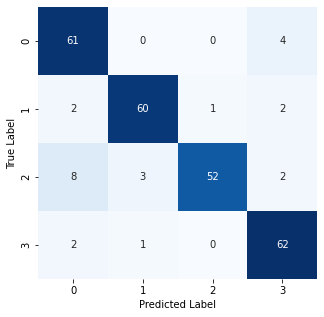

In [48]:
# Confusion matrix
confusion_matrix_color = confusion_matrix(df_test_color['labels_num'], df_test_color['pred_label'])
# plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_color, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 [==============================] - 0s 69ms/step


clubs


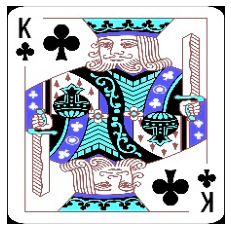

In [49]:
# test for one image
img = cv2.imread('./test_color/clubs/king of clubs_2.jpg')
resize = tf.image.resize(img, (150,150))
yhat = model_color.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(label_to_class_name[max_index])
plt.imshow(img)
plt.axis('off')
plt.show()

# Classification model : type

In [50]:
train_folder_type="./train_type"
test_folder_type="./test_type"
valid_folder_type="./valid_type"

## Réorganisation de la base de données

In [51]:
def process_database_type(source_folder, destination_folder):
    json_data = []

    for directory in os.listdir(source_folder):
        directory_path = os.path.join(source_folder, directory)

        for image in os.listdir(directory_path):
            image_path = os.path.join(directory_path, image)
            
            class_label = directory.split(' ')[0]

            destination_folder_class = os.path.join(destination_folder, class_label)
            if not os.path.exists(destination_folder_class):
                os.makedirs(destination_folder_class)

            nv_nom = directory + '_' + image
            destination_path_image = os.path.join(destination_folder_class, nv_nom)

            shutil.copy(image_path, destination_path_image)

            json_data.append({'filepaths': destination_path_image, 
                            'labels': class_label})

    df = pd.DataFrame(json_data)
    labels = ['ace', 'eight', 'five', 'four', 'jack', 'joker','king', 'nine', 'queen', 'seven', 'six', 'ten', 'three', 'two']
    df['class index'] = df['labels'].apply(lambda x: labels.index(x))

    return df 

In [52]:
df_train_type = process_database_type(train_folder, train_folder_type)

In [53]:
df_test_type = process_database_type(test_folder, test_folder_type)

In [54]:
df_valid_type = process_database_type(valid_folder, valid_folder_type)

## Preprocessing

In [55]:
train_type_ds, label_to_class_name = preprocessing(train_folder_type)
val_type_ds, _ = preprocessing(valid_folder_type)
test_type_ds, _ = preprocessing(test_folder_type)

Found 7624 files belonging to 14 classes.
Found 265 files belonging to 14 classes.
Found 265 files belonging to 14 classes.


## Model construction

In [56]:
# Model construction
model_type = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(14, activation=tf.nn.softmax)
])

# Model visualisation
model_type.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [57]:
# Compilation du modèle
model_type.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

## Model training

In [59]:
# Model training
epochs=10
if os.path.exists('model_type_'+str(epochs)+'_'+str(batch_size)+'.h5'):
  model_type = tf.keras.models.load_model('model_type_'+str(epochs)+'_'+str(batch_size)+'.h5')
else:
  history = model_type.fit(
    train_type_ds,
    validation_data=val_type_ds,
    epochs=epochs
  )
  # Model saving
  model_type.save('model_type_'+str(epochs)+'_'+str(batch_size)+'.h5')

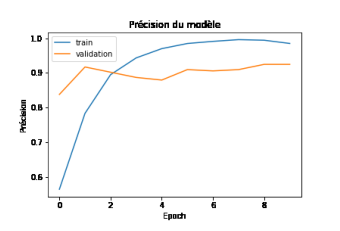

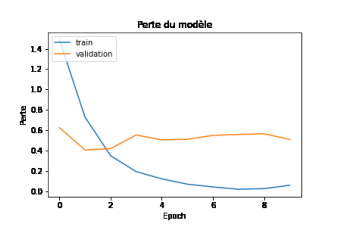

In [60]:
# Visualisation of training graph
if os.path.exists('accuracy_type_'+str(epochs)+'_'+str(batch_size)+'.png') and os.path.exists('loss_type_'+str(epochs)+'_'+str(batch_size)+'.png'):
    plot_existing_graph('accuracy_type_'+str(epochs)+'_'+str(batch_size)+'.png', 'loss_type_'+str(epochs)+'_'+str(batch_size)+'.png')

else:
    plot_history_graph(history, 'accuracy_type_'+str(epochs)+'_'+str(batch_size)+'.png', 'loss_type_'+str(epochs)+'_'+str(batch_size)+'.png')

## Model evaluation

In [61]:
# Model evaluation
model_type.evaluate(test_type_ds)

9/9 [==============================] - 1s 66ms/step - loss: 0.9161 - accuracy: 0.9019


[0.916081964969635, 0.9018868207931519]

In [62]:
label_encoder = LabelEncoder()
df_test_type['labels_num']=label_encoder.fit_transform(df_test_type.labels)
label=df_test_type.labels.unique()

df_test_type.head()

,filepaths,labels,class index,labels_num
0,./test_type/king/king of clubs_2.jpg,king,6,6
1,./test_type/king/king of clubs_4.jpg,king,6,6
2,./test_type/king/king of clubs_5.jpg,king,6,6
3,./test_type/king/king of clubs_1.jpg,king,6,6
4,./test_type/king/king of clubs_3.jpg,king,6,6


In [63]:
pred=[]
for loc in df_test_type.filepaths:
    img = cv2.imread(loc)
    resize = tf.image.resize(img, (150,150))
    yhat = model_type.predict(np.expand_dims(resize/255, 0))
    max_index = np.argmax(yhat)
    pred.append(max_index)
df_test_type['pred_label']=pred

1/1 [==============================] - 0s 35ms/step


In [64]:
class_report = classification_report(df_test_type['labels_num'],df_test_type['pred_label'],target_names=label)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        king       0.80      1.00      0.89        20
         two       0.90      0.95      0.93        20
        five       1.00      0.75      0.86        20
        four       0.86      0.90      0.88        20
       queen       1.00      0.90      0.95        20
        jack       1.00      0.60      0.75         5
       seven       0.76      0.95      0.84        20
         six       0.78      0.70      0.74        20
       eight       0.89      0.80      0.84        20
         ten       0.90      0.95      0.93        20
         ace       0.74      0.85      0.79        20
       joker       0.80      0.80      0.80        20
       three       0.90      0.90      0.90        20
        nine       0.88      0.75      0.81        20

    accuracy                           0.86       265
   macro avg       0.87      0.84      0.85       265
weighted avg       0.87      0.86      0.86       265



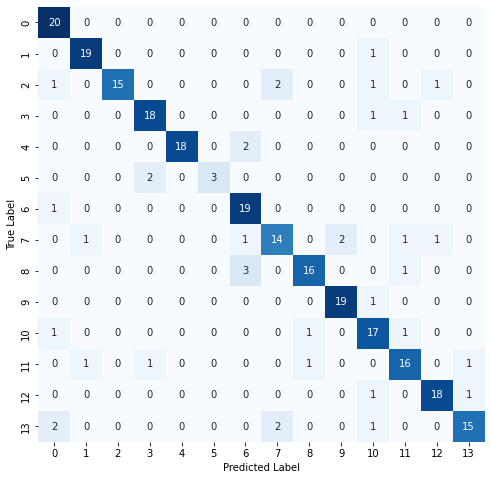

In [65]:
# Confusion matrix
confusion_matrix_type = confusion_matrix(df_test_type['labels_num'], df_test_type['pred_label'])
# plot confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_type, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 [==============================] - 0s 33ms/step
king


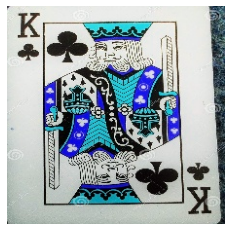

In [66]:
# teste on one image
img = cv2.imread('./test_color/clubs/king of clubs_3.jpg')
resize = tf.image.resize(img, (150,150))
yhat = model_type.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(label_to_class_name[max_index])
plt.imshow(img)
plt.axis('off')
plt.show()

# Combinaison of both models : type and color

## Type classification

In [67]:
pred=[]
for loc in df_test.filepaths:
    img = cv2.imread(loc)
    resize = tf.image.resize(img, (150,150))
    yhat = model_type.predict(np.expand_dims(resize/255, 0))
    max_index = np.argmax(yhat)
    pred.append(max_index)
df_test['pred_label_type']=pred

1/1 [==============================] - 0s 21ms/step


/tmp/ipykernel_8420/829934516.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label_type']=pred


In [76]:
label_to_class_name_type = ['ace', 'eight', 'five', 'four', 'jack', 'joker','king', 'nine', 'queen', 'seven', 'six', 'ten', 'three', 'two']
df_test['pred_label_type_name'] = df_test['pred_label_type'].apply(lambda x: label_to_class_name_type[x])

/tmp/ipykernel_8420/3889793489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label_type_name'] = df_test['pred_label_type'].apply(lambda x: label_to_class_name_type[x])


In [77]:
df_test.head()

,class index,filepaths,labels,card type,data set,labels_num,pred_label,pred_label_type,pred_label_color,pred_label_color_name,pred_label_type_name
7625,0,test/ace of clubs/1.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace
7626,0,test/ace of clubs/2.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace
7627,0,test/ace of clubs/3.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace
7628,0,test/ace of clubs/4.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace
7629,0,test/ace of clubs/5.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace


## Color classification

In [70]:
pred=[]
for loc in df_test.filepaths:
    img = cv2.imread(loc)
    resize = tf.image.resize(img, (150,150))
    yhat = model_color.predict(np.expand_dims(resize/255, 0))
    max_index = np.argmax(yhat)
    pred.append(max_index)
df_test['pred_label_color']=pred

1/1 [==============================] - 0s 20ms/step


/tmp/ipykernel_8420/566158190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label_color']=pred


In [71]:
label_to_class_name_color = ['clubs', 'diamonds', 'hearts', 'spades']
df_test['pred_label_color_name'] = df_test['pred_label_color'].apply(lambda x: label_to_class_name_color[x])

/tmp/ipykernel_8420/2649094910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label_color_name'] = df_test['pred_label_color'].apply(lambda x: label_to_class_name_color[x])


In [73]:
df_test.head()

,class index,filepaths,labels,card type,data set,labels_num,pred_label,pred_label_type,pred_label_color,pred_label_color_name
7625,0,test/ace of clubs/1.jpg,ace of clubs,ace,test,0,0,0,0,clubs
7626,0,test/ace of clubs/2.jpg,ace of clubs,ace,test,0,0,0,0,clubs
7627,0,test/ace of clubs/3.jpg,ace of clubs,ace,test,0,0,0,0,clubs
7628,0,test/ace of clubs/4.jpg,ace of clubs,ace,test,0,0,0,0,clubs
7629,0,test/ace of clubs/5.jpg,ace of clubs,ace,test,0,0,0,0,clubs


## Results merge

In [74]:
def trouver_nom_carte(row):
    if row['pred_label_type_name'] == 'joker':
        return row['pred_label_type_name']
    return row['pred_label_type_name'] + ' of ' + row['pred_label_color_name']

In [78]:
df_test['pred_label_type_color_name'] = df_test.apply(lambda row: trouver_nom_carte(row), axis=1)

/tmp/ipykernel_8420/166842789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label_type_color_name'] = df_test.apply(lambda row: trouver_nom_carte(row), axis=1)


In [79]:
labels = list(df_test['labels'].unique())
df_test['pred_label_type_color'] = df_test['pred_label_type_color_name'].apply(lambda x: labels.index(x))

/tmp/ipykernel_8420/3038385820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label_type_color'] = df_test['pred_label_type_color_name'].apply(lambda x: labels.index(x))


In [80]:
df_test.head()

,class index,filepaths,labels,card type,data set,labels_num,pred_label,pred_label_type,pred_label_color,pred_label_color_name,pred_label_type_name,pred_label_type_color_name,pred_label_type_color
7625,0,test/ace of clubs/1.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace,ace of clubs,0
7626,0,test/ace of clubs/2.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace,ace of clubs,0
7627,0,test/ace of clubs/3.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace,ace of clubs,0
7628,0,test/ace of clubs/4.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace,ace of clubs,0
7629,0,test/ace of clubs/5.jpg,ace of clubs,ace,test,0,0,0,0,clubs,ace,ace of clubs,0


## Evaluation du modèle

In [81]:
label=df_test.labels.unique()
class_report = classification_report(df_test['labels_num'],df_test['pred_label_type_color'],target_names=label)
print("Classification Report:\n", class_report)

Classification Report:
                    precision    recall  f1-score   support

     ace of clubs       0.62      1.00      0.77         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.80      0.80      0.80         5
    ace of spades       0.71      1.00      0.83         5
   eight of clubs       0.71      1.00      0.83         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       1.00      0.60      0.75         5
  eight of spades       0.83      1.00      0.91         5
    five of clubs       1.00      0.60      0.75         5
 five of diamonds       1.00      0.80      0.89         5
   five of hearts       1.00      0.80      0.89         5
   five of spades       1.00      0.80      0.89         5
    four of clubs       0.43      0.60      0.50         5
 four of diamonds       1.00      0.80      0.89         5
   four of hearts       0.83      1.00      0.91         5
   four of spades       1.00   

In [82]:
accuracy = accuracy_score(df_test['labels_num'], df_test['pred_label_type_color'])

print('Accuracy:', accuracy)

Accuracy: 0.7849056603773585


2023-11-30 11:09:21.773112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


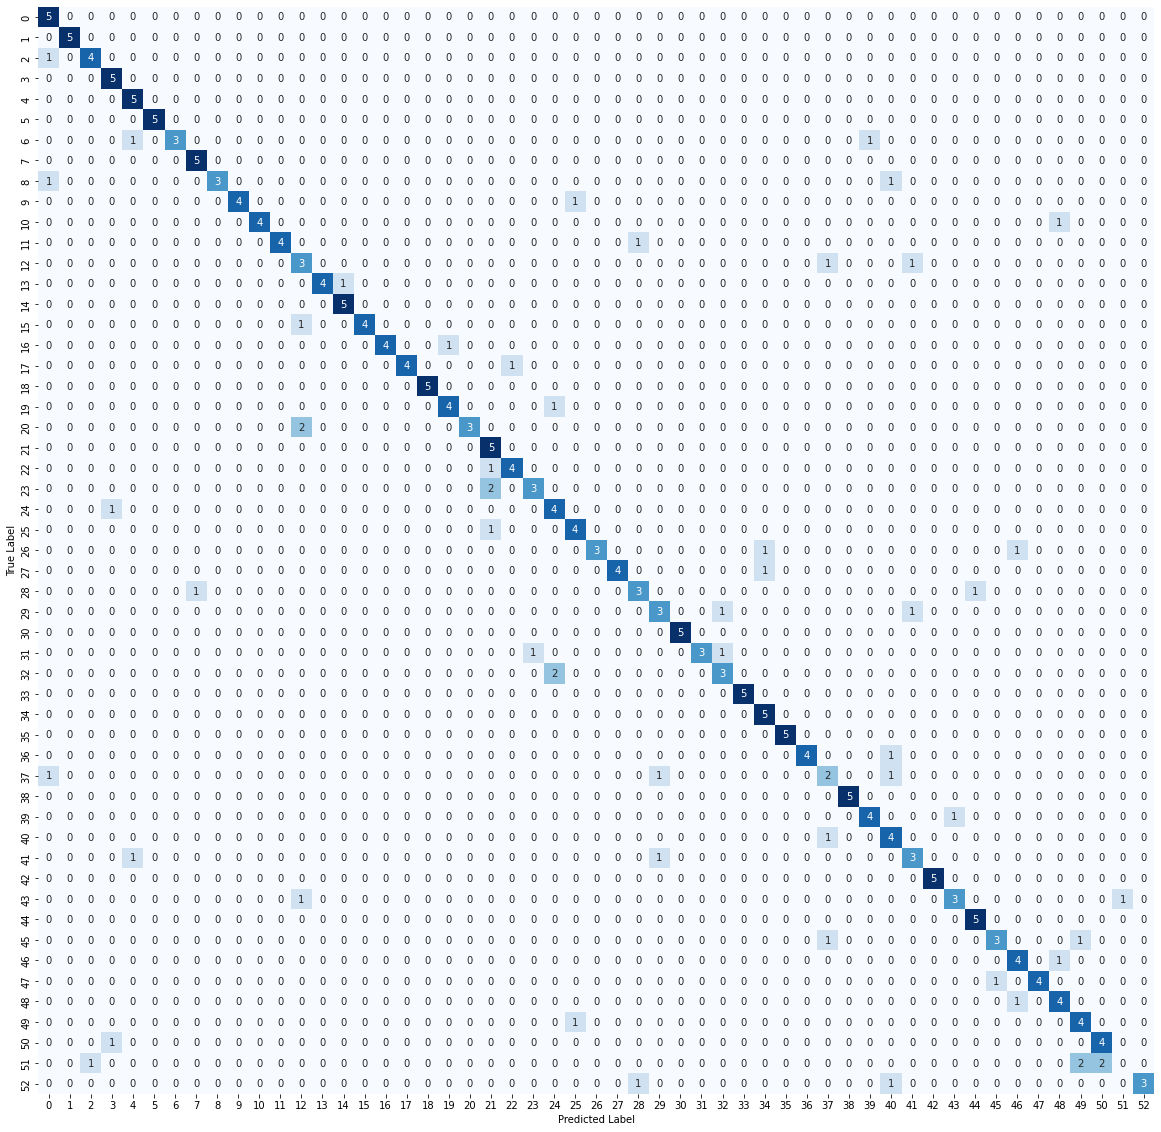

In [83]:
# Confusion matrix
confusion_matrix_type_color_2 = confusion_matrix(df_test['labels_num'], df_test['pred_label_type_color'])
# plot confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix_type_color_2, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()